<a href="https://colab.research.google.com/github/brainopensource/datascience-mvp/blob/ml-analytics-mvp/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MVP de Machine Learning & Analytics para conclusão da Sprint da Pós-Graduação em Ciência de Dados e Analytics (PUC Rio)

Aluno: Lucas da S. Rocha

# Introdução

Este notebook apresenta o desenvolvimento de um Mínimo Produto Viável (MVP) como parte do segundo módulo da Pós-Graduação em Ciência de Dados e Analytics da PUC-Rio. Utilizando dados abertos recentes sobre a produção de petróleo e gás no Brasil, disponibilizados pela Agência Nacional de Petróleo (ANP).

# Código do MVP

## Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import warnings
import missingno as msno
import re

## Configuração do Ambiente

Configurações estéticas do pandas para limitar o máximo de linhas, colunas e filtrar avisos.

In [2]:
# Definindo o limite de exibição colunas de dataframe para None (sem limite)
pd.set_option('display.max_columns', 30)

# Definindo o limite de exibição de linhas de dataframe para 48
pd.set_option('display.max_rows', 145)

# Filter warnings
warnings.filterwarnings('ignore')

## Variáveis Globais

In [3]:
# Data de referência da última produção presente no dado
data_referencia = pd.to_datetime('2024-06-01')

## Funções Auxiliares

In [4]:
def calc_tempo_produzindo(df):
  """
    Calcula o tempo total de produção em meses para cada registro no DataFrame,
    com base no período mínimo de produção registrado por campo.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo informações de produção, incluindo as colunas:
        - 'campo' (identificação do campo de produção)
        - 'periodo' (data do registro de produção, no formato datetime)

    Retorno:
    --------
    pandas.DataFrame
        O DataFrame original com duas novas colunas:
        - 'data_inicio': Data mínima de início de produção por campo.
        - 'tempo_total_producao_meses': Tempo total de produção em meses
          calculado para cada registro desde o início.
    # Encontrar a data mínima de produção por campo
    min_dates = df.groupby('campo')['periodo'].transform('min')  # Transform para alinhar ao DataFrame original
    """

  # Encontrar a data mínima de produção por campo
  min_dates = df.groupby('campo')['periodo'].transform('min')  # Transform para alinhar ao DataFrame original

  # Adicionar a data mínima ao DataFrame original
  df['data_inicio'] = min_dates

  # Calcular o tempo total de produção em meses para cada registro
  df['tempo_total_producao_meses'] = ((df['periodo'].dt.year - df['data_inicio'].dt.year) * 12 +
                                        (df['periodo'].dt.month - df['data_inicio'].dt.month))

  return df

## Criando dataframe
Os datasets obtidos de dados abertos da ANP foram compilados num arquivo de formato 'parquet'. Ele contem dados de 1980 até 2024 com as produções por poços em campos offshore na costa Brasileira.

Foram usadas técnicas de pré-processamento do módulo lecionado no trimestre anterior, fazendo uso dos conceitos apresentados para preparar o dataset pra ser utilizado posteriormente.

Conforme sugerido, os dados foram disponibilizados publicamente no repositório do Github e lidos no formato Raw.

[Link do Repositório](https://github.com/brainopensource/datascience-mvp)

[Fonte de Informação de dados abertos](https://cdp.anp.gov.br/ords/r/cdp_apex/consulta-dados-publicos-cdp/consulta-produ%C3%A7%C3%A3o-por-po%C3%A7o)

In [5]:
url = "https://raw.githubusercontent.com/brainopensource/datascience-mvp/refs/heads/ml-analytics-mvp/datasets/monthly_production_concat/1980_2024_BR_production_data.parquet"

df_prod_base = pd.read_parquet(url).reset_index(drop=True)

# Exibindo um subset com os dados referente ao campo TUPI e seus tipos de dados por coluna
display(df_prod_base[df_prod_base['campo'] == 'TUPI'].head(5))

print(df_prod_base.dtypes)

,estado,bacia,nome_poco_anp,campo,periodo,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,tempo_producao_hspormes,ano,mes
14,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-01-01,13.188175,0.0,13.188175,21.049140,0.0,21.049140,0.0,0,2011,1
30,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-02-01,14.871802,0.0,14.871802,24.602713,0.0,24.602713,0.0,0,2011,2
37,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-03-01,14.601435,0.0,14.601435,24.307998,0.0,24.307998,0.0,0,2011,3
54,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-04-01,21.318976,0.0,21.318976,36.219512,0.0,36.219512,0.0,0,2011,4
72,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-05-01,28.436432,0.0,28.436432,44.274315,0.0,44.274315,0.0,0,2011,5


estado                              object
bacia                               object
nome_poco_anp                       object
campo                               object
periodo                     datetime64[ns]
oleo_kbd                           float64
condensado_kbd                     float64
petroleo_kbd                       float64
gas_natural_mmscf_assoc            float64
gas_natural_mmscf_nassoc           float64
gas_natural_mmscf_total            float64
agua_kbd                           float64
tempo_producao_hspormes              int64
ano                                  int32
mes                                  int32
dtype: object


In [6]:
# Criando uma cópia do dataframe e listando todos os campos presentes no registro
df_prod = df_prod_base.copy(deep=True)
campos = df_prod['campo'].unique()

## Transformações de dado

Nesse MVP iremos trabalhar com as produções por campo, agregando as produções de petróleo, água, gás e condensados por campo e por período mensal, pois é a granularidade da nossa base de dados.

In [7]:
# Converte a coluna 'periodo' para o formato datetime, tratando valores inválidos como NaT (Not a Time)
df_prod['periodo'] = pd.to_datetime(df_prod['periodo'], errors='coerce')

# Criando um mapeamento único de campo -> bacia
bacia_por_campo = df_prod[['campo', 'bacia']].drop_duplicates().set_index('campo')

# Agrupamento dos dados por campo
df_fields_prod = df_prod.groupby(['campo', 'periodo']).agg(
    oleo_kbd_total=('oleo_kbd', 'sum'),
    condensado_kbd_total=('condensado_kbd', 'sum'),
    petroleo_kbd_total=('petroleo_kbd', 'sum'),
    gas_natural_mmscf_assoc_total=('gas_natural_mmscf_assoc', 'sum'),
    gas_natural_mmscf_nassoc_total=('gas_natural_mmscf_nassoc', 'sum'),
    gas_natural_mmscf_total_total=('gas_natural_mmscf_total', 'sum'),
    agua_kbd_total=('agua_kbd', 'sum'),
    tempo_producao_hspormes_total=('tempo_producao_hspormes', 'sum')
).reset_index()

# Adicionar a coluna 'bacia' ao resultado final a partir do mapeamento
df_fields_prod['bacia'] = df_fields_prod['campo'].map(bacia_por_campo['bacia'])

# Exibir o DataFrame auxiliar
display(df_fields_prod.head(2))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia
0,ABALONE,2009-07-01,1.019355,0.0,1.019355,3.605638,0.0,3.605638,0.0,292,Campos
1,ABALONE,2009-08-01,0.670778,0.0,0.670778,2.061891,0.0,2.061891,0.0,178,Campos


In [8]:
# Selecionar apenas os campos da Bacia de Santos numa lista
campos_santos = (bacia_por_campo[bacia_por_campo.bacia == 'Santos']).index.tolist()

In [9]:
# Calcular o número de dias em cada mês do período
df_fields_prod['dias_no_mes'] = df_fields_prod['periodo'].dt.days_in_month

# Calcular a produção total do mês em barris (KBD * dias_no_mes)
df_fields_prod['oleo_kb_total_mes'] = df_fields_prod['oleo_kbd_total'] * df_fields_prod['dias_no_mes']

# Calcular a produção acumulada campo
df_fields_prod['producao_acumulada'] = df_fields_prod.groupby('campo')['oleo_kb_total_mes'].cumsum()

# Ordenar o dado por período e por campo
df_fields_prod.sort_values(by=['periodo', 'campo'], inplace=True)

In [10]:
# Aplicar a função ao DataFrame e calcular o tempo total de produção do campo que sinaliza a maturidade do campo
df_fields_prod = calc_tempo_produzindo(df_fields_prod)

In [11]:
# Exibir algumas linhas para verificar as novas colunas
display(df_fields_prod.head(5))
display(df_fields_prod.tail(5))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,dias_no_mes,oleo_kb_total_mes,producao_acumulada,data_inicio,tempo_total_producao_meses
180,AGULHA,1980-01-01,5.687206,0.0,5.687206,3.063783,0.0,3.063783,0.113075,0,Potiguar,31,176.303374,176.303374,1980-01-01,0
2512,AREA DO SES-2,1980-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,Sergipe,31,0.000000,0.000000,1980-01-01,0
6156,BONITO,1980-01-01,3.853138,0.0,3.853138,1.852973,0.0,1.852973,0.000000,0,Campos,31,119.447266,119.447266,1980-01-01,0
6953,CAIOBA,1980-01-01,8.026630,0.0,8.026630,21.512356,0.0,21.512356,1.122630,0,Sergipe,31,248.825518,248.825518,1980-01-01,0
7709,CAMORIM,1980-01-01,3.093186,0.0,3.093186,9.161707,0.0,9.161707,0.011667,0,Sergipe,31,95.888781,95.888781,1980-01-01,0


,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,dias_no_mes,oleo_kb_total_mes,producao_acumulada,data_inicio,tempo_total_producao_meses
29626,TUBARÃO MARTELO,2024-06-01,7.491990,0.000000,7.491990,0.708060,0.000000,0.708060,4.116145,3397,Campos,30,224.759712,3.227508e+04,2013-12-01,126
29808,TUPI,2024-06-01,787.079691,0.000000,787.079691,1402.080312,0.000000,1402.080312,119.784603,34368,Santos,30,23612.390733,2.822499e+06,2009-04-01,182
30481,URUGUÁ,2024-06-01,2.185382,0.028356,2.213738,1.966330,1.082456,3.048785,2.742418,1486,Santos,30,65.561472,4.022173e+04,2010-07-01,167
30904,VERMELHO,2024-06-01,6.829628,0.000000,6.829628,0.881699,0.000000,0.881699,75.755939,10872,Campos,30,204.888846,1.734700e+05,1989-01-01,425
31643,VOADOR,2024-06-01,5.288838,0.000000,5.288838,5.505039,0.000000,5.505039,0.029656,923,Campos,30,158.665137,8.341508e+04,1992-11-01,379


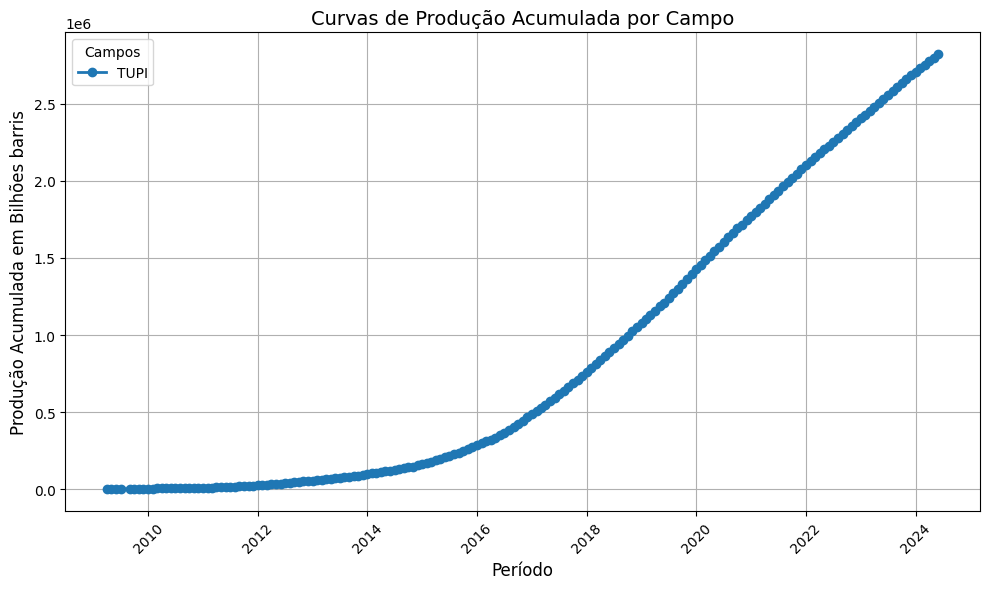

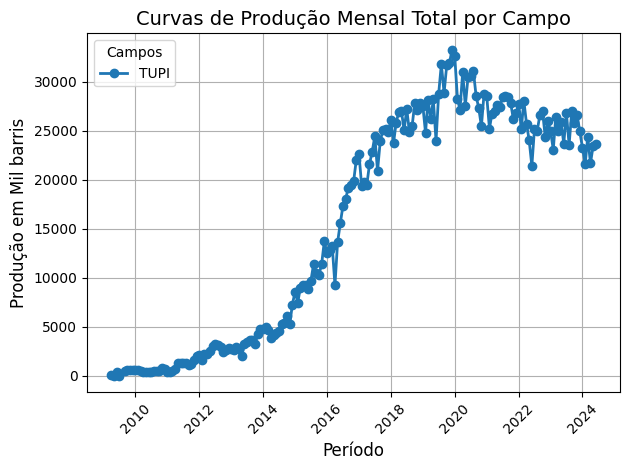

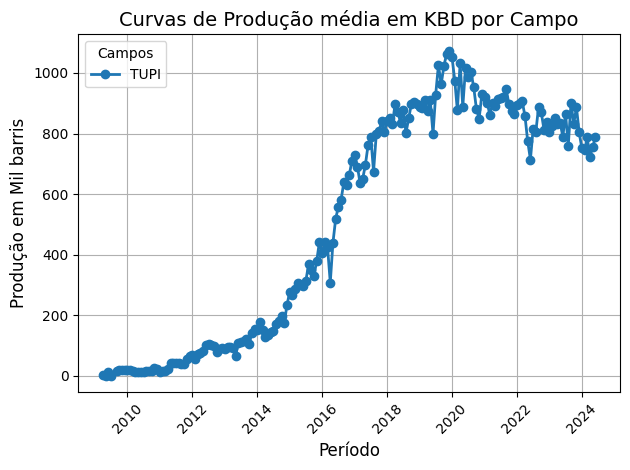

In [12]:
# Criar um gráfico de produção acumulada para TUPI
plt.figure(figsize=(10, 6))

# Plotar a produção acumulada
for campo in ['TUPI']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['producao_acumulada'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção Acumulada por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção Acumulada em Bilhões barris', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotar a produção total mensal
for campo in ['TUPI']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['oleo_kb_total_mes'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção Mensal Total por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção em Mil barris', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotar a produção média em KBD mensalmente
for campo in ['TUPI']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['oleo_kbd_total'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção média em KBD por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção em Mil barris', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## MACHINE LEARNING

Nessa seção iremos treinar os modelos de Machine Learning usando as técnicas de Regressão Linear, Gradient Boosting,


Numa primeira versão do modelo iremos utilizar as features:
 - tempo em meses que o campo produz desde o primeiro óleo
 - produção de petróleo em mil barris
 - campo que produziu

In [178]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [209]:
display(df_fields_prod.head(3))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,dias_no_mes,oleo_kb_total_mes,producao_acumulada,data_inicio,tempo_total_producao_meses
180,AGULHA,1980-01-01,5.687206,0.0,5.687206,3.063783,0.0,3.063783,0.113075,0,Potiguar,31,176.303374,176.303374,1980-01-01,0
2512,AREA DO SES-2,1980-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,Sergipe,31,0.000000,0.000000,1980-01-01,0
6156,BONITO,1980-01-01,3.853138,0.0,3.853138,1.852973,0.0,1.852973,0.000000,0,Campos,31,119.447266,119.447266,1980-01-01,0


### Análise de Modelos

#### Preparação

In [179]:
# A coluna producao corresponde de petróleo em barris de cada campo em cada período e será o alvo de nosso estudo
df_fields = df_fields_prod[['campo', 'tempo_total_producao_meses', 'oleo_kbd_total', 'producao_acumulada']]

# Definir um limiar para produção baixa
limiar_producao = 1e5  # Exemplo de limiar

# Filtrar os campos que produzem abaixo do limiar
campos_filtrados = df_fields[df_fields['producao_acumulada'] >= limiar_producao]['campo']

# Filtrar o DataFrame original para manter apenas os campos com produção alta
df_fields = df_fields[df_fields['campo'].isin(campos_filtrados)]

print(campos_filtrados)

# Agrupar por 'campo' e pegar o valor máximo de 'producao_acumulada'
#df_max_producao_acumulada = df_fields_filtrado.groupby('campo')['producao_acumulada'].max().reset_index()

# Exibir a tabela com o valor máximo de produção acumulada para cada campo
#display(df_max_producao_acumulada.sort_values(by='producao_acumulada', ascending=False).reset_index().head(100))

# Removendo a coluna de produção acumulada pois não sera usada no
df_fields = df_fields[['campo', 'tempo_total_producao_meses', 'oleo_kbd_total']]

21433           NAMORADO
21434           NAMORADO
21435           NAMORADO
21436           NAMORADO
22775              PAMPO
              ...       
27276           SAPINHOÁ
27730        SUL DE TUPI
28591    TARTARUGA VERDE
29808               TUPI
30904           VERMELHO
Name: campo, Length: 7193, dtype: object


In [180]:
# Passo 1: Gerar a sequência completa de meses para cada campo (de 1 até o máximo)
df_complete = []

for campo in df_fields['campo'].unique():
    df_campo = df_fields[df_fields['campo'] == campo]

    # Gerar todos os meses do 1 até o máximo de 'tempo_total_producao_meses'
    meses_completos = pd.DataFrame({'tempo_total_producao_meses': np.arange(1, df_campo['tempo_total_producao_meses'].max() + 1)})

    # Passo 2: Mesclar com o df original para garantir que todos os meses estão presentes
    df_campo_completo = pd.merge(meses_completos, df_campo[['campo', 'tempo_total_producao_meses', 'oleo_kbd_total']],
                                  how='left', on='tempo_total_producao_meses')

    # Passo 3: Preencher valores ausentes com zero
    df_campo_completo['oleo_kbd_total'] = df_campo_completo['oleo_kbd_total'].fillna(0)

    # Adicionar o campo identificador para manter a informação do campo
    df_campo_completo['campo'] = campo

    # Adicionar à lista completa
    df_complete.append(df_campo_completo)

# Concatenar os DataFrames de todos os campos
df_fields = pd.concat(df_complete, ignore_index=True)

# Exibir as primeiras linhas do DataFrame completo
display(df_fields.head(3))

,tempo_total_producao_meses,campo,oleo_kbd_total
0,1,BONITO,3.766967
1,2,BONITO,3.007158
2,3,BONITO,2.124698


In [181]:
# Listas para armazenar os DataFrames de treino e teste
list_dfs_train = []
list_dfs_test = []

# Iterar sobre cada campo
for campo in df_fields['campo'].unique():

  # Filtrar os dados para o campo atual
  df_campo = df_fields[df_fields['campo'] == campo]

  # Ordenar por 'tempo_total_producao_meses' (ou 'periodo' se necessário)
  df_campo_sorted = df_campo.sort_values(by='tempo_total_producao_meses')

  # Determinar o índice de corte para 70% de dados para treino
  train_size = int(len(df_campo_sorted) * 0.7)

  # Separar os dados em treino (70%) e teste (30%)
  df_train = df_campo_sorted.iloc[:train_size]
  df_test = df_campo_sorted.iloc[train_size:]

  # Adicionar os DataFrames de treino e teste nas respectivas listas
  list_dfs_train.append(df_train)
  list_dfs_test.append(df_test)

  """
  # COMENTADO PARA AUMENTO DE PERFORMANCE DE EXECUÇÃO
  # Plotando os dados de treino e teste
  plt.figure(figsize=(10, 6))

  # Plot para dados de treino
  plt.plot(df_train['tempo_total_producao_meses'], df_train['oleo_kbd_total'],
            color='red', label='Treino', alpha=0.6)

  # Plot para dados de teste
  plt.plot(df_test['tempo_total_producao_meses'], df_test['oleo_kbd_total'],
            color='purple', label='Teste', alpha=0.6)

  # Títulos e rótulos
  plt.title(f'Campo: {campo} - Dados de Treino e Teste', fontsize=14)
  plt.xlabel('Tempo Total de Produção (Meses)', fontsize=12)
  plt.ylabel('Produção de Óleo (KBD)', fontsize=12)

  # Exibindo a legenda
  plt.legend()

  # Exibindo o gráfico
  plt.show()

  """

In [182]:
# Concatenar os DataFrames de treino e teste
df_train_final = pd.concat(list_dfs_train, ignore_index=True)
df_test_final = pd.concat(list_dfs_test, ignore_index=True)

# Mostrar os DataFrames finais para treino e teste
print("Dados de Treinamento:", df_train_final.shape)
print("Dados de Teste:", df_test_final.shape)
display(df_train_final.head(3))
display(df_test_final.head(3))

Dados de Treinamento: (8548, 3)
Dados de Teste: (3685, 3)


,tempo_total_producao_meses,campo,oleo_kbd_total
0,1,BONITO,3.766967
1,2,BONITO,3.007158
2,3,BONITO,2.124698


,tempo_total_producao_meses,campo,oleo_kbd_total
0,374,BONITO,5.159844
1,375,BONITO,4.697849
2,376,BONITO,3.673891


#### One-hot Encoding

In [183]:
# Inicializando o OneHotEncoder (drop_first=True para evitar multicolinearidade)
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustando o encoder com os dados de treino (ajustando para as categorias presentes em df_train_final)
X_train_encoded = encoder.fit_transform(df_train_final[['campo']])

# Transformando o conjunto de teste com o encoder ajustado (usando o mesmo encoding do treino)
X_test_encoded = encoder.transform(df_test_final[['campo']])

# Convertendo os resultados em DataFrames para facilitar a manipulação
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['campo']))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(['campo']))

# Adicionando de volta as colunas numéricas (tempo_total_producao_meses) aos datasets de treino e teste
X_train = pd.concat([df_train_final[['tempo_total_producao_meses']].reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([df_test_final[['tempo_total_producao_meses']].reset_index(drop=True), X_test_encoded_df], axis=1)

# Separando a variável target 'oleo_kbd_total' (ou qualquer outra variável alvo)
y_train = df_train_final['oleo_kbd_total']
y_test = df_test_final['oleo_kbd_total']

In [184]:
# Procurar o índice do campo
campo = 'MARLIM SUL'
num_meses_futuro = 12 * 20  # Número de meses para prever

#### 1 Linear Regression

In [185]:
from sklearn.linear_model import LinearRegression

In [186]:
# Treinando o modelo Linear Regression
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = model_linear.predict(X_test)

# Calculando as métricas de qualidade do modelo
mae_linear = mean_absolute_error(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
r2_linear = r2_score(y_test, y_pred)

# Exibindo os resultados
print(f'MAE: {mae_linear}')
print(f'MSE: {mse_linear}')
print(f'R2: {r2_linear}')

MAE: 58.58268454427295
MSE: 8158.620896866026
R2: 0.4154954016811856


In [187]:
# Filtrando o DataFrame para o campo específico
df_campo = df_fields[df_fields['campo'] == campo]
display(df_campo.head(3))

# Encontrando o período máximo para esse campo
periodo_maximo = df_campo['tempo_total_producao_meses'].max()
print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

# Definindo o tempo inicial (último mês registrado + 1)
tempo_total_producao_meses = periodo_maximo + 1

,tempo_total_producao_meses,campo,oleo_kbd_total
7536,1,MARLIM SUL,8.339476
7537,2,MARLIM SUL,7.972397
7538,3,MARLIM SUL,9.165045


O período máximo para o campo MARLIM SUL é: 362


O período máximo para o campo MARLIM SUL é: 362


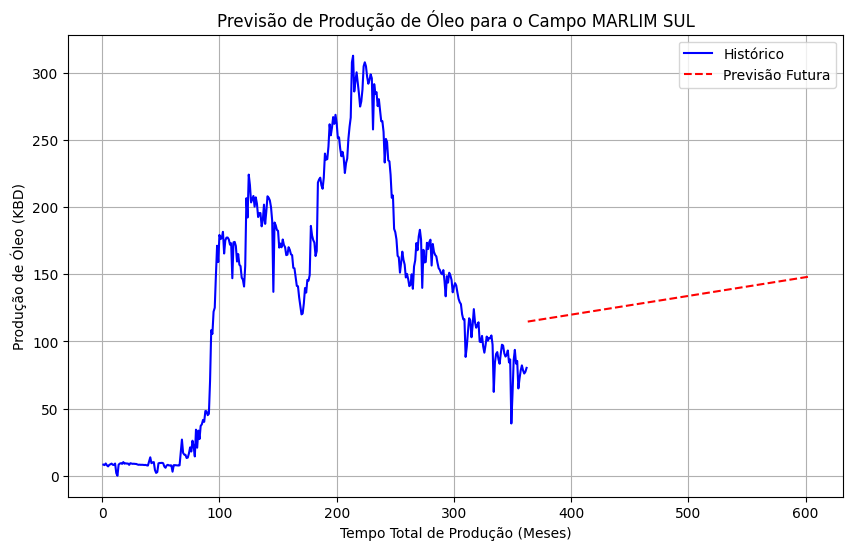

Previsão de produção para o campo MARLIM SUL no mês 602: 148.08 KBD


In [188]:
# Codificando a variável 'campo' com One-Hot Encoding
X = df_fields[['tempo_total_producao_meses', 'campo']]  # Features: tempo de produção e campo
y = df_fields['oleo_kbd_total']  # Alvo: produção de óleo

# Codificando 'campo' com One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Gerando previsões para os próximos 120 meses para cada campo
campos = df_fields['campo'].unique()  # Identificando os campos únicos

for campo in [campo]:
    # Filtrando o dataframe para o campo específico
    df_campo = df_fields[df_fields['campo'] == campo]

    # Encontrando o período máximo para esse campo
    periodo_maximo = df_campo['tempo_total_producao_meses'].max()
    print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

    # Criando os dados para os próximos 120 meses
    tempo_total_producao_meses = periodo_maximo + 1  # Tempo inicial (último mês + 1)

    # Criando os dados para prever os próximos 120 meses
    X_futuro = pd.DataFrame({
        'tempo_total_producao_meses': [tempo_total_producao_meses + i for i in range(num_meses_futuro)],  # 120 meses
        'campo': [campo] * num_meses_futuro  # Repetindo o campo para todos os meses
    })

    # Aplicando o One-Hot Encoding para as variáveis
    X_futuro = pd.get_dummies(X_futuro, drop_first=True)

    # Garantindo que as colunas de X_futuro correspondam exatamente às de X (no caso da codificação)
    X_futuro = X_futuro.reindex(columns=X.columns, fill_value=0)

    # Fazendo a previsão para os próximos 120 meses
    y_futuro = model_linear.predict(X_futuro)

    # Exibindo o gráfico com o histórico e as previsões futuras
    plt.figure(figsize=(10, 6))
    plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total'], label='Histórico', color='blue')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro, label='Previsão Futura', color='red', linestyle='--')
    plt.title(f'Previsão de Produção de Óleo para o Campo {campo}')
    plt.xlabel('Tempo Total de Produção (Meses)')
    plt.ylabel('Produção de Óleo (KBD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Exibindo o resultado da previsão para o último mês
    print(f'Previsão de produção para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_futuro[-1]:.2f} KBD')

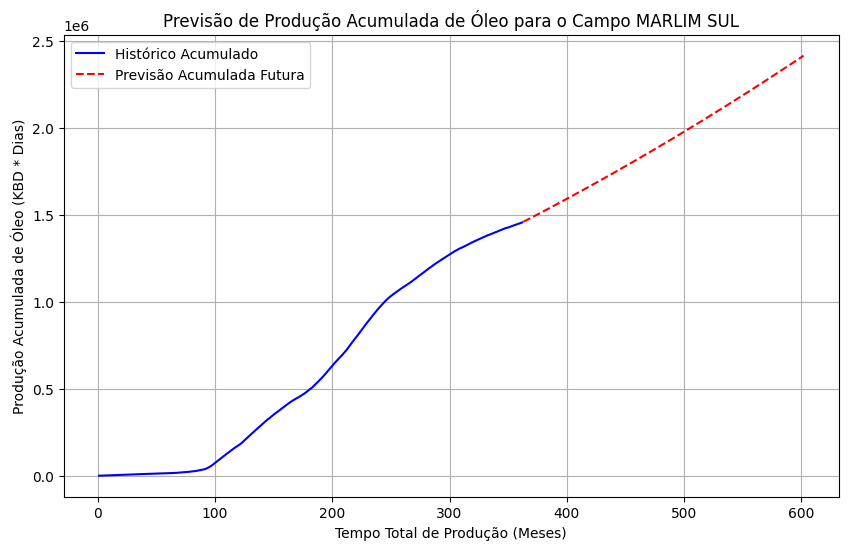

Previsão de produção acumulada para o campo MARLIM SUL no mês 602: 2417246.77 KBD * Dias


In [189]:
# Convertendo a produção para a base de dias
df_campo['oleo_kbd_total'] = df_campo['oleo_kbd_total'] * 30.42  # Convertendo para dias

# Calculando a produção acumulada histórica (para os meses históricos)
df_campo['oleo_kbd_total_acumulado'] = df_campo['oleo_kbd_total'].cumsum()

# Garantindo que a produção acumulada futura seja contínua (sem salto)
# A produção acumulada futura começa a partir da última produção acumulada histórica
y_acumulada_futura = y_futuro.cumsum() * 30.42  # Produção acumulada futura em dias
y_acumulada_futura = y_acumulada_futura + df_campo['oleo_kbd_total_acumulado'].iloc[-1]  # Somando ao último valor acumulado histórico

# Exibindo o gráfico com o histórico e as previsões acumuladas futuras de forma contínua
plt.figure(figsize=(10, 6))
plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total_acumulado'], label='Histórico Acumulado', color='blue')
plt.plot(X_futuro['tempo_total_producao_meses'], y_acumulada_futura, label='Previsão Acumulada Futura', color='red', linestyle='--')
plt.title(f'Previsão de Produção Acumulada de Óleo para o Campo {campo}')
plt.xlabel('Tempo Total de Produção (Meses)')
plt.ylabel('Produção Acumulada de Óleo (KBD * Dias)')
plt.legend()
plt.grid(True)
plt.show()

# Exibindo o resultado da previsão acumulada para o último mês
print(f'Previsão de produção acumulada para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_acumulada_futura[-1]:.2f} KBD * Dias')


#### 2 Gradient Boosting

In [190]:
from xgboost import XGBRegressor

"""best_params = {
    'n_estimators': 100,
    'max_depth': 7,
    'learning_rate': 0.2,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'random_state': 42
}"""

# Criando o modelo com os melhores parâmetros
model_gboost = XGBRegressor(random_state=42)

model_gboost.fit(X_train, y_train)

y_pred = model_gboost.predict(X_test)

mae_gboost = mean_absolute_error(y_test, y_pred)
mse_gboost = mean_squared_error(y_test, y_pred)
r2_gboost = r2_score(y_test, y_pred)

print(f'MAE: {mae_gboost}')
print(f'MSE: {mse_gboost}')
print(f'R2: {r2_gboost}')

MAE: 24.38139097896403
MSE: 2887.447382987154
R2: 0.7931358382630666


O período máximo para o campo MARLIM SUL é: 362


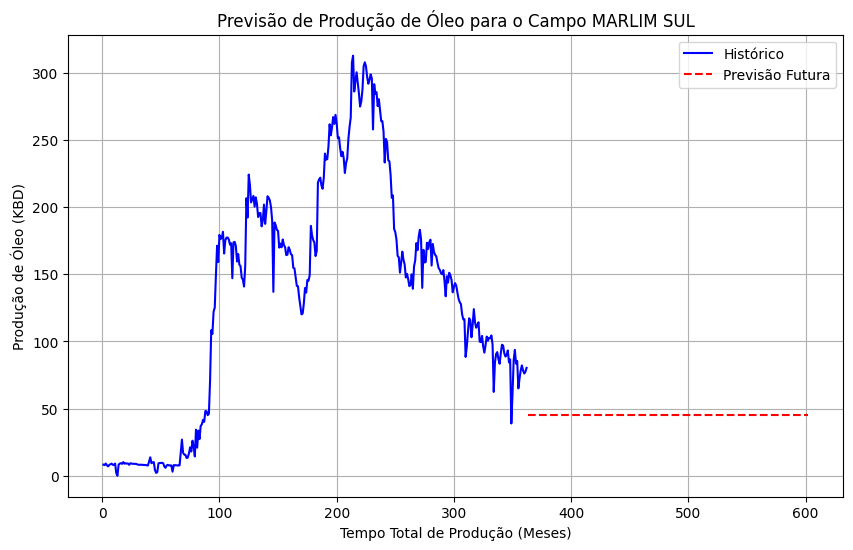

Previsão de produção para o campo MARLIM SUL no mês 602: 45.35 KBD


In [191]:
# Codificando a variável 'campo' com One-Hot Encoding
X = df_fields[['tempo_total_producao_meses', 'campo']]  # Features: tempo de produção e campo
y = df_fields['oleo_kbd_total']  # Alvo: produção de óleo

# Codificando 'campo' com One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Gerando previsões para os próximos 120 meses para cada campo
campos = df_fields['campo'].unique()  # Identificando os campos únicos

for campo in [campo]:
    # Filtrando o dataframe para o campo específico
    df_campo = df_fields[df_fields['campo'] == campo]

    # Encontrando o período máximo para esse campo
    periodo_maximo = df_campo['tempo_total_producao_meses'].max()
    print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

    # Criando os dados para os próximos 120 meses
    tempo_total_producao_meses = periodo_maximo + 1  # Tempo inicial (último mês + 1)

    # Criando os dados para prever os próximos 120 meses
    X_futuro = pd.DataFrame({
        'tempo_total_producao_meses': [tempo_total_producao_meses + i for i in range(num_meses_futuro)],  # 120 meses
        'campo': [campo] * num_meses_futuro  # Repetindo o campo para todos os meses
    })

    # Aplicando o One-Hot Encoding para as variáveis
    X_futuro = pd.get_dummies(X_futuro, drop_first=True)

    # Garantindo que as colunas de X_futuro correspondam exatamente às de X (no caso da codificação)
    X_futuro = X_futuro.reindex(columns=X.columns, fill_value=0)

    # Fazendo a previsão para os próximos 120 meses
    y_futuro = model_gboost.predict(X_futuro)

    # Exibindo o gráfico com o histórico e as previsões futuras
    plt.figure(figsize=(10, 6))
    plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total'], label='Histórico', color='blue')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro, label='Previsão Futura', color='red', linestyle='--')
    plt.title(f'Previsão de Produção de Óleo para o Campo {campo}')
    plt.xlabel('Tempo Total de Produção (Meses)')
    plt.ylabel('Produção de Óleo (KBD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Exibindo o resultado da previsão para o último mês
    print(f'Previsão de produção para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_futuro[-1]:.2f} KBD')

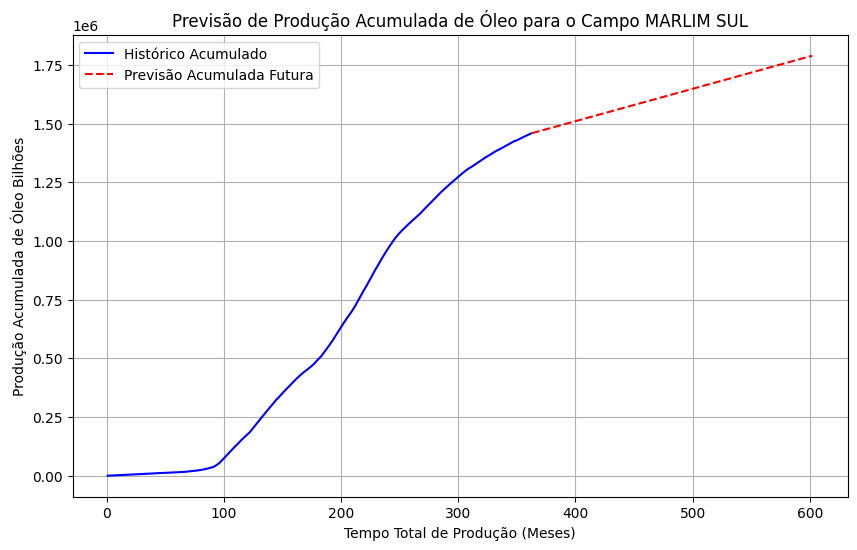

Previsão de produção acumulada para o campo MARLIM SUL no mês 602: 1788857.25 de Barris


In [192]:
# Convertendo a produção para a base de dias
df_campo['oleo_kbd_total'] = df_campo['oleo_kbd_total'] * 30.42  # Convertendo para dias

# Calculando a produção acumulada histórica (para os meses históricos)
df_campo['oleo_kbd_total_acumulado'] = df_campo['oleo_kbd_total'].cumsum()

# Garantindo que a produção acumulada futura seja contínua (sem salto)
# A produção acumulada futura começa a partir da última produção acumulada histórica
y_acumulada_futura = y_futuro.cumsum() * 30.42  # Produção acumulada futura em dias
y_acumulada_futura = y_acumulada_futura + df_campo['oleo_kbd_total_acumulado'].iloc[-1]  # Somando ao último valor acumulado histórico

# Exibindo o gráfico com o histórico e as previsões acumuladas futuras de forma contínua
plt.figure(figsize=(10, 6))
plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total_acumulado'], label='Histórico Acumulado', color='blue')
plt.plot(X_futuro['tempo_total_producao_meses'], y_acumulada_futura, label='Previsão Acumulada Futura', color='red', linestyle='--')
plt.title(f'Previsão de Produção Acumulada de Óleo para o Campo {campo}')
plt.xlabel('Tempo Total de Produção (Meses)')
plt.ylabel('Produção Acumulada de Óleo Bilhões')
plt.legend()
plt.grid(True)
plt.show()

# Exibindo o resultado da previsão acumulada para o último mês
print(f'Previsão de produção acumulada para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_acumulada_futura[-1]:.2f} de Barris')


#### 3 LightGBM

In [193]:
from lightgbm import LGBMRegressor

# Criando e treinando o modelo LightGBM
model_lgbm = LGBMRegressor(random_state=42)
model_lgbm.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_lgbm = model_lgbm.predict(X_test)

# Avaliando o modelo
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f'MAE: {mae_lgbm}')
print(f'MSE: {mse_lgbm}')
print(f'R2: {r2_lgbm}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 8548, number of used features: 40
[LightGBM] [Info] Start training from score 53.231655
MAE: 27.418111007528083
MSE: 3106.3238047651616
R2: 0.7774549681000765


O período máximo para o campo MARLIM SUL é: 362


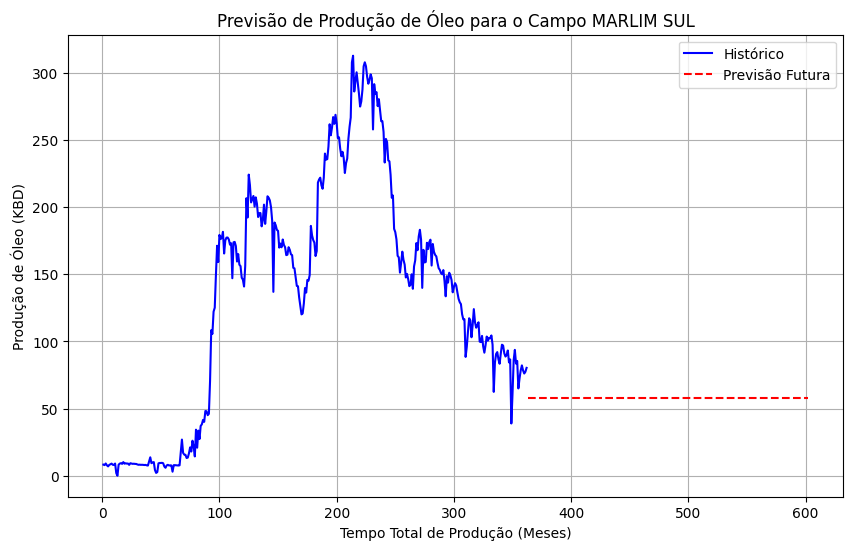

Previsão de produção para o campo MARLIM SUL no mês 602: 58.03 KBD


In [194]:
# Codificando a variável 'campo' com One-Hot Encoding
X = df_fields[['tempo_total_producao_meses', 'campo']]  # Features: tempo de produção e campo
y = df_fields['oleo_kbd_total']  # Alvo: produção de óleo

# Codificando 'campo' com One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Gerando previsões para os próximos 120 meses para cada campo
campos = df_fields['campo'].unique()  # Identificando os campos únicos

for campo in [campo]:
    # Filtrando o dataframe para o campo específico
    df_campo = df_fields[df_fields['campo'] == campo]

    # Encontrando o período máximo para esse campo
    periodo_maximo = df_campo['tempo_total_producao_meses'].max()
    print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

    # Criando os dados para os próximos 120 meses
    tempo_total_producao_meses = periodo_maximo + 1  # Tempo inicial (último mês + 1)

    # Criando os dados para prever os próximos 120 meses
    X_futuro = pd.DataFrame({
        'tempo_total_producao_meses': [tempo_total_producao_meses + i for i in range(num_meses_futuro)],  # 120 meses
        'campo': [campo] * num_meses_futuro  # Repetindo o campo para todos os meses
    })

    # Aplicando o One-Hot Encoding para as variáveis
    X_futuro = pd.get_dummies(X_futuro, drop_first=True)

    # Garantindo que as colunas de X_futuro correspondam exatamente às de X (no caso da codificação)
    X_futuro = X_futuro.reindex(columns=X.columns, fill_value=0)

    # Fazendo a previsão para os próximos 120 meses
    y_futuro = model_lgbm.predict(X_futuro)

    # Exibindo o gráfico com o histórico e as previsões futuras
    plt.figure(figsize=(10, 6))
    plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total'], label='Histórico', color='blue')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro, label='Previsão Futura', color='red', linestyle='--')
    plt.title(f'Previsão de Produção de Óleo para o Campo {campo}')
    plt.xlabel('Tempo Total de Produção (Meses)')
    plt.ylabel('Produção de Óleo (KBD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Exibindo o resultado da previsão para o último mês
    print(f'Previsão de produção para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_futuro[-1]:.2f} KBD')

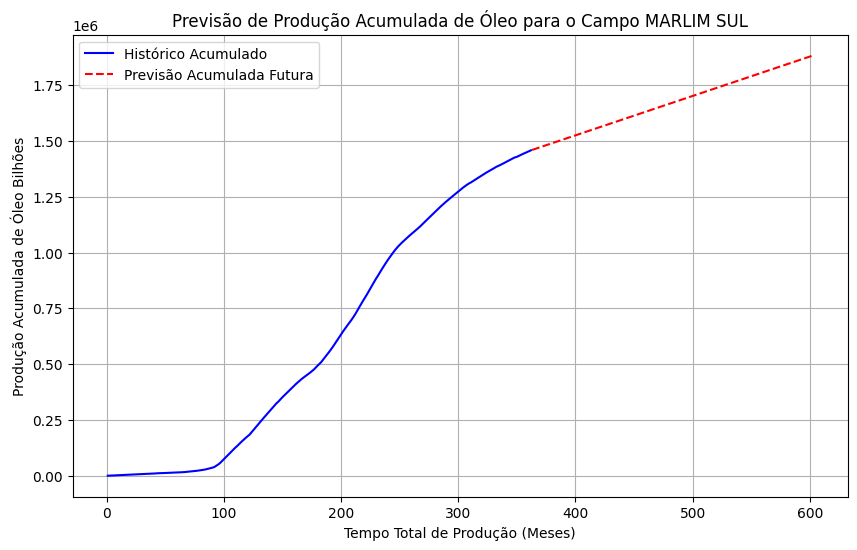

Previsão de produção acumulada para o campo MARLIM SUL no mês 602: 1881437.27 de Barris


In [195]:
# Convertendo a produção para a base de dias
df_campo['oleo_kbd_total'] = df_campo['oleo_kbd_total'] * 30.42  # Convertendo para dias

# Calculando a produção acumulada histórica (para os meses históricos)
df_campo['oleo_kbd_total_acumulado'] = df_campo['oleo_kbd_total'].cumsum()

# Garantindo que a produção acumulada futura seja contínua (sem salto)
# A produção acumulada futura começa a partir da última produção acumulada histórica
y_acumulada_futura = y_futuro.cumsum() * 30.42  # Produção acumulada futura em dias
y_acumulada_futura = y_acumulada_futura + df_campo['oleo_kbd_total_acumulado'].iloc[-1]  # Somando ao último valor acumulado histórico

# Exibindo o gráfico com o histórico e as previsões acumuladas futuras de forma contínua
plt.figure(figsize=(10, 6))
plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total_acumulado'], label='Histórico Acumulado', color='blue')
plt.plot(X_futuro['tempo_total_producao_meses'], y_acumulada_futura, label='Previsão Acumulada Futura', color='red', linestyle='--')
plt.title(f'Previsão de Produção Acumulada de Óleo para o Campo {campo}')
plt.xlabel('Tempo Total de Produção (Meses)')
plt.ylabel('Produção Acumulada de Óleo Bilhões')
plt.legend()
plt.grid(True)
plt.show()

# Exibindo o resultado da previsão acumulada para o último mês
print(f'Previsão de produção acumulada para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_acumulada_futura[-1]:.2f} de Barris')


#### 4 Rede Neural

In [204]:
from sklearn.neural_network import MLPRegressor

# Criando e treinando o modelo de rede neural
model_ann = MLPRegressor(hidden_layer_sizes=(100,), max_iter=600, learning_rate_init=0.001, learning_rate='adaptive', random_state=42)

model_ann.fit(X_train, y_train)

# Fazendo previsões
y_pred_ann = model_ann.predict(X_test)

# Avaliando o modelo
mae_ann = mean_absolute_error(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)
print(f'MAE: {mae_ann}')
print(f'MSE: {mse_ann}')
print(f'R2: {r2_ann}')

MAE: 28.801673530170536
MSE: 3340.5959299514902
R2: 0.760671110122078


O período máximo para o campo MARLIM SUL é: 362


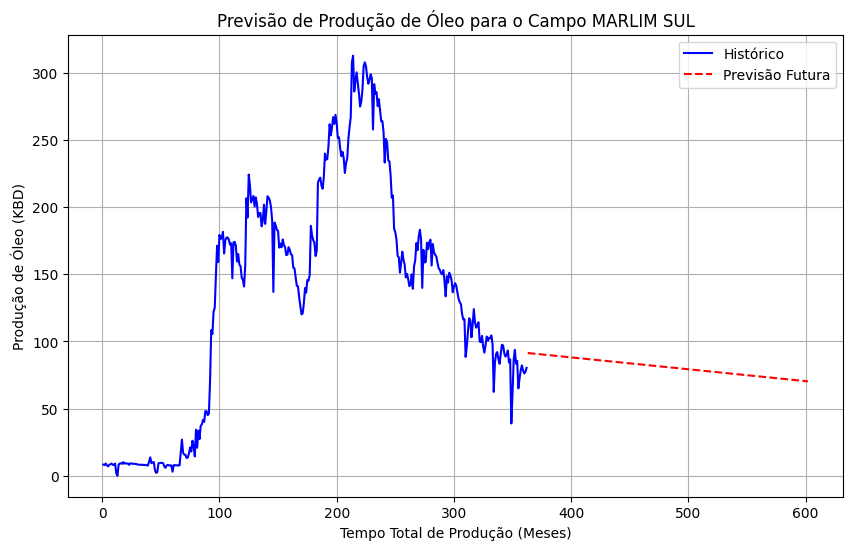

Previsão de produção para o campo MARLIM SUL no mês 602: 70.29 KBD


In [205]:
# Codificando a variável 'campo' com One-Hot Encoding
X = df_fields[['tempo_total_producao_meses', 'campo']]  # Features: tempo de produção e campo
y = df_fields['oleo_kbd_total']  # Alvo: produção de óleo

# Codificando 'campo' com One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Gerando previsões para os próximos 120 meses para cada campo
campos = df_fields['campo'].unique()  # Identificando os campos únicos

for campo in [campo]:
    # Filtrando o dataframe para o campo específico
    df_campo = df_fields[df_fields['campo'] == campo]

    # Encontrando o período máximo para esse campo
    periodo_maximo = df_campo['tempo_total_producao_meses'].max()
    print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

    # Criando os dados para os próximos 120 meses
    tempo_total_producao_meses = periodo_maximo + 1  # Tempo inicial (último mês + 1)

    # Criando os dados para prever os próximos 120 meses
    X_futuro = pd.DataFrame({
        'tempo_total_producao_meses': [tempo_total_producao_meses + i for i in range(num_meses_futuro)],  # 120 meses
        'campo': [campo] * num_meses_futuro  # Repetindo o campo para todos os meses
    })

    # Aplicando o One-Hot Encoding para as variáveis
    X_futuro = pd.get_dummies(X_futuro, drop_first=True)

    # Garantindo que as colunas de X_futuro correspondam exatamente às de X (no caso da codificação)
    X_futuro = X_futuro.reindex(columns=X.columns, fill_value=0)

    # Fazendo a previsão para os próximos 120 meses
    y_futuro = model_ann.predict(X_futuro)

    # Exibindo o gráfico com o histórico e as previsões futuras
    plt.figure(figsize=(10, 6))
    plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total'], label='Histórico', color='blue')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro, label='Previsão Futura', color='red', linestyle='--')
    plt.title(f'Previsão de Produção de Óleo para o Campo {campo}')
    plt.xlabel('Tempo Total de Produção (Meses)')
    plt.ylabel('Produção de Óleo (KBD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Exibindo o resultado da previsão para o último mês
    print(f'Previsão de produção para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_futuro[-1]:.2f} KBD')

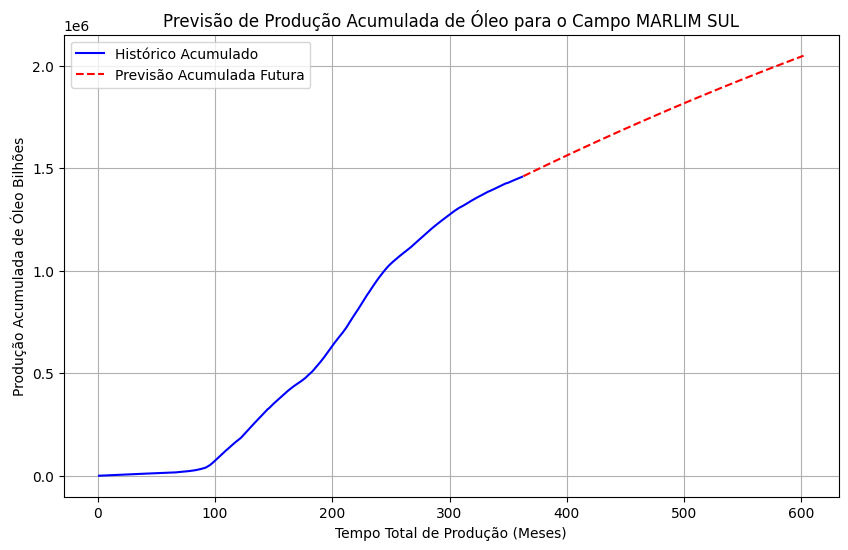

Previsão de produção acumulada para o campo MARLIM SUL no mês 602: 2047903.80 de Barris


In [206]:
# Convertendo a produção para a base de dias
df_campo['oleo_kbd_total'] = df_campo['oleo_kbd_total'] * 30.42  # Convertendo para dias

# Calculando a produção acumulada histórica (para os meses históricos)
df_campo['oleo_kbd_total_acumulado'] = df_campo['oleo_kbd_total'].cumsum()

# Garantindo que a produção acumulada futura seja contínua (sem salto)
# A produção acumulada futura começa a partir da última produção acumulada histórica
y_acumulada_futura = y_futuro.cumsum() * 30.42  # Produção acumulada futura em dias
y_acumulada_futura = y_acumulada_futura + df_campo['oleo_kbd_total_acumulado'].iloc[-1]  # Somando ao último valor acumulado histórico

# Exibindo o gráfico com o histórico e as previsões acumuladas futuras de forma contínua
plt.figure(figsize=(10, 6))
plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total_acumulado'], label='Histórico Acumulado', color='blue')
plt.plot(X_futuro['tempo_total_producao_meses'], y_acumulada_futura, label='Previsão Acumulada Futura', color='red', linestyle='--')
plt.title(f'Previsão de Produção Acumulada de Óleo para o Campo {campo}')
plt.xlabel('Tempo Total de Produção (Meses)')
plt.ylabel('Produção Acumulada de Óleo Bilhões')
plt.legend()
plt.grid(True)
plt.show()

# Exibindo o resultado da previsão acumulada para o último mês
print(f'Previsão de produção acumulada para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_acumulada_futura[-1]:.2f} de Barris')


#### Comparação dos modelos

In [207]:
# Criando um dicionário com os resultados dos modelos
results = {
    'Modelo': ['LGBM', 'Gradient Boosting', 'Regressão Linear', 'Redes Neurais'],
    'MAE': [mae_lgbm, mae_gboost, mae_linear, mae_ann],
    'MSE': [mse_lgbm, mse_gboost, mse_linear, mse_ann],
    'R2': [r2_lgbm, r2_gboost, r2_linear, r2_ann]
}

# Criando um DataFrame com os resultados
df_results = pd.DataFrame(results)

# Exibindo o DataFrame
print(df_results)

              Modelo        MAE          MSE        R2
0               LGBM  27.418111  3106.323805  0.777455
1  Gradient Boosting  24.381391  2887.447383  0.793136
2   Regressão Linear  58.582685  8158.620897  0.415495
3      Redes Neurais  28.801674  3340.595930  0.760671


### Otimização

In [ ]:
# Função para gerar sequência de meses por campo
def completar_meses(df):
    df_complete = []
    for campo in df['campo'].unique():
        df_campo = df[df['campo'] == campo]

        # Gerar todos os meses do 1 até o máximo de 'tempo_total_producao_meses'
        max_meses = df_campo['tempo_total_producao_meses'].max()
        meses_completos = pd.DataFrame({'tempo_total_producao_meses': np.arange(1, max_meses + 1)})

        # Mesclar com os dados originais e preencher valores ausentes
        df_campo_completo = pd.merge(meses_completos,
                                     df_campo[['campo', 'tempo_total_producao_meses', 'oleo_kbd_total']],
                                     how='left', on='tempo_total_producao_meses')
        df_campo_completo['oleo_kbd_total'] = df_campo_completo['oleo_kbd_total'].fillna(0)
        df_campo_completo['campo'] = campo

        df_complete.append(df_campo_completo)
    return pd.concat(df_complete, ignore_index=True)


# Função para dividir os dados em treino e teste
def dividir_treino_teste(df, proporcao_treino=0.7):
    dfs_train, dfs_test = [], []

    for campo in df['campo'].unique():
        df_campo = df[df['campo'] == campo].sort_values(by='tempo_total_producao_meses')

        # Índice de corte baseado na proporção definida
        corte = int(len(df_campo) * proporcao_treino)
        dfs_train.append(df_campo.iloc[:corte])
        dfs_test.append(df_campo.iloc[corte:])

    return pd.concat(dfs_train, ignore_index=True), pd.concat(dfs_test, ignore_index=True)

In [ ]:
# Engenharia de features

# Features para o modelo
lista_de_features = [
    'campo', 'oleo_kbd_total', 'oleo_kb_total_mes',
    'gas_natural_mmscf_total_total', 'agua_kbd_total', 'dias_no_mes']

# Filtragem de campos com produção acumulada >= limiar
limiar_producao = 1e5  # Exemplo de limiar
df_fields = df_fields_prod[df_fields_prod['producao_acumulada'] >= limiar_producao][lista_de_features]

# Preencher meses ausentes
df_fields = completar_meses(df_fields)

# Separar os dados
df_train, df_test = dividir_treino_teste(df_fields)

# Exibir resultados iniciais para validação
print("Conjunto de Treino:")
display(df_train.head())
print("Conjunto de Teste:")
display(df_test.head())
